In the Lagrangian system we have a different setup, with cells and cell-walls.  Scalar quantities such as P, $\nu$, and I are defined  in the cell and other quantities need to be defined on the walls/boundaries, such as u and pos. x.  There exist also 2 ghost cells on the ends to take care of boundary conditions, such that if the  array  $1<i<n$ then the ghost cells exist at $i=0$ and $i=n+1$.

$$|\quad.\quad|\quad.\quad|\quad.\quad|\quad.\quad|\quad.\quad|\quad.\quad|\quad.\quad|
\quad.\quad|\quad.\quad|\quad $$

Here the | are defined by indices such as $x_{i+\frac{1}{2}}$ and $u_{i+\frac{1}{2}}$ and the cells . are have indices like $p_i$ and $I_i$.  Using our old trick of the finite difference scheme, we can get the time rate of change of the wall-positions or nodal positions:

$$ x^{n+1}_{i+\frac{1}{2}}= x^n_{i+\frac{1}{2}} + u^n_{i+\frac{1}{2}} dt$$

Old Newton comes into play as the nodal positions move due to the pressure one cell exerts upon another.  Like

$$F_j=A\left( p_j + q_j \right)$$

Math math excettera we come down to the equation

$$ u^{n+1}_{i+\frac{1}{2}}=u^n_{i+\frac{1}{2}}+\frac{dt}{M}\left(p^n_i + q^n_i -
p^n_{i+1} - q^n_{i+1}\right) $$

The density per cell is discover then by;

$$\rho^n_i=\frac{M}{x^n_{i+\frac{1}{2}}-x^n_{i-\frac{1}{2}}}$$

Now taking into account the viscous pressure q, we can think of this as the heat produced over the compressive change in a volume $\frac{-Q}{\Delta V}$.  Moving on very quickly and discretising this we see that :

$$I^{n+1}_i=I^n_i+\frac{dt}{M}\left(p^n_i + q^n_i \right)\left(u^n_{i-\frac{1}{2}} - u^n_{i+\frac{1}{2}} \right)$$

Finally we need an equation of state to link these two equations, that takes the form:

$$p^n_j=\left(\gamma -1 \right)\rho^n_j I^n_j$$

Some common values for $\gamma$ are:1.4, 1.66, 1.34, 1.08 for air, He, CO2, and SF6.  Looking back at q, this serves as a dissipation of KE as the creation of heat through friction.

$$q^n_j= q_0 \rho^n_j c\left(u^n_{i-\frac{1}{2}} - u^n_{i+\frac{1}{2}} \right)$$

In [141]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from tempfile import NamedTemporaryFile
from IPython.display import HTML


%matplotlib inline

In [142]:
# -------------------- #
#        Constants     #
# -------------------- #
q0=.3
gamma=5./3. #7
rho0=1.                     # g/cc
ul=.5                   # the velocity at the left end of the cylinder
ur=0                     # the velocity at the right end of the cylinder
dt=.005                   # seconds
sie0=0                   # internal energy at t=0 cm^2/s^2
length=10                # cm

n_nodes=60               # number of the nodes, CELLS HAVE LEN n_nodes-1



In [143]:
# ---------------------------------------- #
#            Array intialization           #
# ---------------------------------------- #
x=np.linspace(0,length,n_nodes)
rho=np.zeros(n_nodes-1)+rho0

# Not sure how to specify these
u=np.zeros(n_nodes)

p=np.zeros(n_nodes-1)
q=np.zeros(n_nodes-1)
c=np.zeros(n_nodes-1)
sie=np.zeros(n_nodes-1)



In [144]:
dumps={'rho':[],'pos':[],'pres':[],'visc':[],'vel':[],'c':[]}
t=0.0

Q=0
M=rho[1]*(x[2]-x[1])

dumps['rho'].append(rho.copy())
dumps['pos'].append(x.copy())
dumps['vel'].append(u.copy())
dumps['pres'].append(p.copy())
dumps['visc'].append(q.copy())

while t<=10:
    t+=dt
    # STEP 0: Boundary Conditions
    if t>5:
        u[0]=ul
        u[-1]=ur
    else:
        u[0]=ul
        u[-1]=ur
    
    # STEP 1: UPDATE NODE POSITIONS
    for i in range(n_nodes):
        x[i]=x[i]+u[i]*dt
    
    # STEP 2: UPDATE VELOCITIES
    for i in range(1,n_nodes-1):
        u[i]=u[i]+dt/M*(p[i-1]+q[i-1]-p[i]-q[i])
        
    # STEP 3: UPDATE DENSITIES
    for i in range(n_nodes-1):
        rho[i]=M/(x[i+1]-x[i])

    # STEP 4: UPDATE INTERNAL ENERGY I (SIE)
    for i in range(n_nodes-1):
        sie[i]=sie[i]+dt/M*(p[i]+q[i])*(u[i]-u[i+1])
        
    # STEP 5: UPDATE THE PRESSURE
    for i in range(n_nodes-1):
        p[i]=(gamma-1)*rho[i]*sie[i]
        
    # STEP 6: UPDATE THE Sound Speed
    for i in range(n_nodes-1):
        c[i]=ul+np.sqrt(gamma*(gamma-1)*sie[i])
    
    # STEP 7: UPDATE THE VISCOSITY
    for i in range(n_nodes-1):
        Q=q0*rho[i]*c[i]*(u[i]-u[i+1])
        if Q>=0:
            q[i]=Q
        else:
            q[i]=0
            

    if (round(t,2)%1.0==0.0):
        dumps['rho'].append(rho.copy())
        dumps['pos'].append(x.copy())
        dumps['vel'].append(u.copy())
        dumps['pres'].append(p.copy())
        dumps['visc'].append(q.copy())
        dumps['c'].append(c.copy())

In [145]:
VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=5, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)
def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    b=np.insert(dumps['rho'][i],0,0)
    a=dumps['pos'][i]
    line.set_data(a,b)
    return line,

In [146]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 10), ylim=(0, 5))
line, = ax.plot([], [], 'k-o', lw=2,)


# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(dumps['vel']), interval=2000, blit=True)

# call our new function to display the animation
display_animation(anim)

(0, 10)

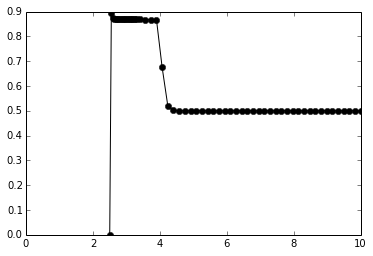

In [151]:
i=10
b=np.insert(dumps['c'][i],0,0)
a=dumps['pos'][i]
plt.plot(a,b,'k-o')
plt.xlim(0,10)

In [148]:
'''
dumps={'rho':[],'pos':[],'pres':[],'visc':[],'vel':[]}
t=0.0

Q=0
M=rho[1]/(x[2]-x[1])

dumps['rho'].append(rho.copy())
dumps['pos'].append(x.copy())
while t<=10:
    t+=dt
    # STEP 0: Boundary Conditions
    u[0]=ul
    u[-1]=ur
    
    # STEP 1: UPDATE NODE POSITIONS
    for i in range(n_nodes):
        x[i]=x[i]+u[i]*dt
    
    # STEP 2: UPDATE VELOCITIES
    for i in range(1,n_nodes-2):
        u[i]=u[i]+dt/M*(p[i]+q[i]-p[i+1]-q[i+1])
        
    # STEP 3: UPDATE DENSITIES
    for i in range(1,n_nodes-1):
        rho[i]=M/(x[i]-x[i-1])

    # STEP 4: UPDATE INTERNAL ENERGY I (SIE)
    for i in range(1,n_nodes-1):
        sie[i]=sie[i]+dt/M*(p[i]+q[i])*(u[i-1]-u[i])
        
    # STEP 5: UPDATE THE PRESSURE
    for i in range(n_nodes-1):
        p[i]=(gamma-1)*rho[i]*sie[i]
    
    # STEP 6: UPDATE THE VISCOSITY
    for i in range(1,n_nodes-1):
        Q=q0*rho[i]*(u[i-1]-u[i])
        if Q>=0:
            q[i]=Q
        else:
            q[i]=0
            

    if (round(t,2)%1.0==0.0):
        dumps['rho'].append(rho.copy())
        dumps['pos'].append(x.copy())
'''

"\ndumps={'rho':[],'pos':[],'pres':[],'visc':[],'vel':[]}\nt=0.0\n\nQ=0\nM=rho[1]/(x[2]-x[1])\n\ndumps['rho'].append(rho.copy())\ndumps['pos'].append(x.copy())\nwhile t<=10:\n    t+=dt\n    # STEP 0: Boundary Conditions\n    u[0]=ul\n    u[-1]=ur\n    \n    # STEP 1: UPDATE NODE POSITIONS\n    for i in range(n_nodes):\n        x[i]=x[i]+u[i]*dt\n    \n    # STEP 2: UPDATE VELOCITIES\n    for i in range(1,n_nodes-2):\n        u[i]=u[i]+dt/M*(p[i]+q[i]-p[i+1]-q[i+1])\n        \n    # STEP 3: UPDATE DENSITIES\n    for i in range(1,n_nodes-1):\n        rho[i]=M/(x[i]-x[i-1])\n\n    # STEP 4: UPDATE INTERNAL ENERGY I (SIE)\n    for i in range(1,n_nodes-1):\n        sie[i]=sie[i]+dt/M*(p[i]+q[i])*(u[i-1]-u[i])\n        \n    # STEP 5: UPDATE THE PRESSURE\n    for i in range(n_nodes-1):\n        p[i]=(gamma-1)*rho[i]*sie[i]\n    \n    # STEP 6: UPDATE THE VISCOSITY\n    for i in range(1,n_nodes-1):\n        Q=q0*rho[i]*(u[i-1]-u[i])\n        if Q>=0:\n            q[i]=Q\n        else:\n      

In [149]:
g=np.array([1,2,3,4])
a=np.insert(g,0,10)

In [150]:
a

array([10,  1,  2,  3,  4])